<a href="https://colab.research.google.com/github/dhyan1999/DL_ML/blob/master/CGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Input, Flatten, Embedding, multiply, Dropout
from keras.optimizers import Adam
from keras import initializers

[[[-0.00797666  0.01356199]
  [-0.03308342 -0.02512537]
  [ 0.01135672 -0.03441805]
  [-0.01187042 -0.04409304]
  [-0.03912523 -0.01906285]
  [ 0.04206051  0.02007847]
  [ 0.00455785  0.02527875]
  [ 0.01889339  0.03371624]
  [-0.04934168  0.04237027]
  [ 0.00452316 -0.00467687]]]


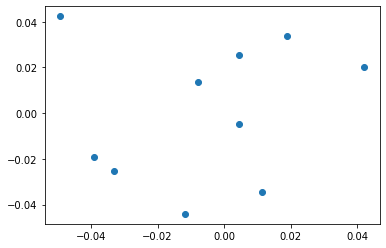

In [3]:
model = Sequential()
model.add(Embedding(10, 2))
input_array = np.arange(0, 10).reshape(1, -1)
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array)
plt.scatter(output_array[0, :, 0], output_array[0, :, 1])

In [4]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


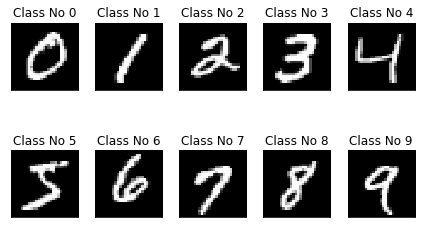

In [5]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class No %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

In [6]:
X_train.shape

(60000, 28, 28)

In [7]:
y_train.shape

(60000,)

In [8]:
X_train = X_train.reshape(60000, 28*28)
X_train = (X_train.astype('float32') / 255 - 0.5) * 2
print('X_train reshape:', X_train.shape)

X_train reshape: (60000, 784)


Generator Model

In [9]:
latent_dim = 100

img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

generator = Sequential()

generator.add(Dense(128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Dense(img_dim, activation='tanh'))

In [10]:
# prints a summary representation of your model
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)              

In [11]:
num_classes = 10
label = Input(shape=(1,), dtype='int32')
label_embedding = Embedding(num_classes, latent_dim)(label)
label_embedding = Flatten()(label_embedding)
z = Input(shape=(latent_dim,))
input_generator = multiply([z, label_embedding])
img = generator(input_generator)
generator = Model([z, label], img)

In [12]:
# Model Summary
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       1000        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 100)          0           embedding_1[0][0]                
______________________________________________________________________________________________

Discriminator

In [13]:
discriminator = Sequential()

discriminator.add(Dense(128, input_shape=(img_dim,), kernel_initializer=init))
discriminator.add(LeakyReLU(alpha=0.2))

discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))

discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))

discriminator.add(Dense(1, activation='sigmoid'))

In [14]:
# Model Summary
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [15]:
label_d = Input(shape=(1,), dtype='int32')
label_embedding_d = Embedding(num_classes, img_dim)(label_d)
label_embedding_d = Flatten()(label_embedding_d)
img_d = Input(shape=(img_dim,))
input_discriminator = multiply([img_d, label_embedding_d])
validity = discriminator(input_discriminator)
discriminator = Model([img_d, label_d], validity)

Model visualization

In [16]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 784)       7840        input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           embedding_2[0][0]                
____________________________________________________________________________________________

In [17]:
optimizer = Adam(lr=0.0002, beta_1=0.5)

In [18]:
discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [19]:
discriminator.trainable = False

validity = discriminator([generator([z, label]), label])

In [20]:
d_g = Model([z, label], validity)

d_g.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [21]:
d_g.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 784)          584312      input_2[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 1)            273441      model[0][0]                

Epoch ==> 1/100, Discrim_loss=0.658, Generat_loss=1.003                                                                                                     


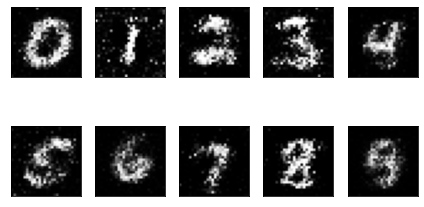

Epoch ==> 2/100, Discrim_loss=0.656, Generat_loss=0.885                                                                                                     
Epoch ==> 3/100, Discrim_loss=0.677, Generat_loss=0.833                                                                                                     
Epoch ==> 4/100, Discrim_loss=0.681, Generat_loss=0.827                                                                                                     
Epoch ==> 5/100, Discrim_loss=0.680, Generat_loss=0.778                                                                                                     
Epoch ==> 6/100, Discrim_loss=0.674, Generat_loss=0.793                                                                                                     
Epoch ==> 7/100, Discrim_loss=0.679, Generat_loss=0.812                                                                                                     
Epoch ==> 8/100, Discrim_loss=0.700, Generat_loss=0.817   

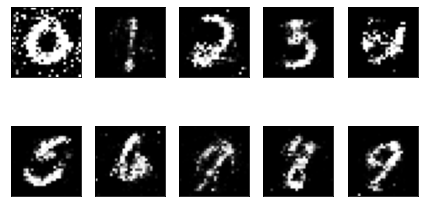

Epoch ==> 12/100, Discrim_loss=0.627, Generat_loss=0.930                                                                                                     
Epoch ==> 13/100, Discrim_loss=0.673, Generat_loss=0.862                                                                                                     
Epoch ==> 14/100, Discrim_loss=0.670, Generat_loss=0.844                                                                                                     
Epoch ==> 15/100, Discrim_loss=0.656, Generat_loss=0.872                                                                                                     
Epoch ==> 16/100, Discrim_loss=0.670, Generat_loss=0.826                                                                                                     
Epoch ==> 17/100, Discrim_loss=0.657, Generat_loss=0.895                                                                                                     
Epoch ==> 18/100, Discrim_loss=0.645, Generat_loss=0

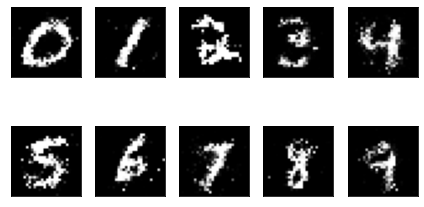

Epoch ==> 22/100, Discrim_loss=0.657, Generat_loss=0.833                                                                                                     
Epoch ==> 23/100, Discrim_loss=0.657, Generat_loss=0.878                                                                                                     
Epoch ==> 24/100, Discrim_loss=0.682, Generat_loss=0.842                                                                                                     
Epoch ==> 25/100, Discrim_loss=0.656, Generat_loss=0.898                                                                                                     
Epoch ==> 26/100, Discrim_loss=0.665, Generat_loss=0.873                                                                                                     
Epoch ==> 27/100, Discrim_loss=0.671, Generat_loss=0.833                                                                                                     
Epoch ==> 28/100, Discrim_loss=0.651, Generat_loss=0

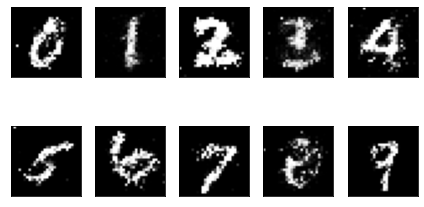

Epoch ==> 32/100, Discrim_loss=0.679, Generat_loss=0.840                                                                                                     
Epoch ==> 33/100, Discrim_loss=0.680, Generat_loss=0.853                                                                                                     
Epoch ==> 34/100, Discrim_loss=0.650, Generat_loss=0.924                                                                                                     
Epoch ==> 35/100, Discrim_loss=0.668, Generat_loss=0.825                                                                                                     
Epoch ==> 36/100, Discrim_loss=0.667, Generat_loss=0.872                                                                                                     
Epoch ==> 37/100, Discrim_loss=0.664, Generat_loss=0.840                                                                                                     
Epoch ==> 38/100, Discrim_loss=0.688, Generat_loss=0

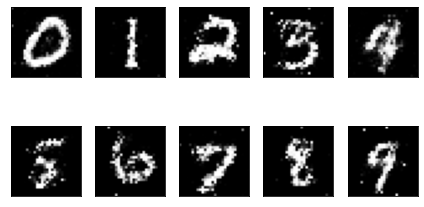

Epoch ==> 42/100, Discrim_loss=0.654, Generat_loss=0.913                                                                                                     
Epoch ==> 43/100, Discrim_loss=0.664, Generat_loss=0.828                                                                                                     
Epoch ==> 44/100, Discrim_loss=0.638, Generat_loss=0.858                                                                                                     
Epoch ==> 45/100, Discrim_loss=0.656, Generat_loss=0.858                                                                                                     
Epoch ==> 46/100, Discrim_loss=0.668, Generat_loss=0.876                                                                                                     
Epoch ==> 47/100, Discrim_loss=0.651, Generat_loss=0.813                                                                                                     
Epoch ==> 48/100, Discrim_loss=0.650, Generat_loss=0

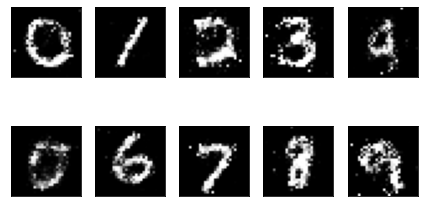

Epoch ==> 52/100, Discrim_loss=0.657, Generat_loss=0.854                                                                                                     
Epoch ==> 53/100, Discrim_loss=0.686, Generat_loss=0.837                                                                                                     
Epoch ==> 54/100, Discrim_loss=0.666, Generat_loss=0.838                                                                                                     
Epoch ==> 55/100, Discrim_loss=0.670, Generat_loss=0.851                                                                                                     
Epoch ==> 56/100, Discrim_loss=0.688, Generat_loss=0.819                                                                                                     
Epoch ==> 57/100, Discrim_loss=0.654, Generat_loss=0.824                                                                                                     
Epoch ==> 58/100, Discrim_loss=0.640, Generat_loss=0

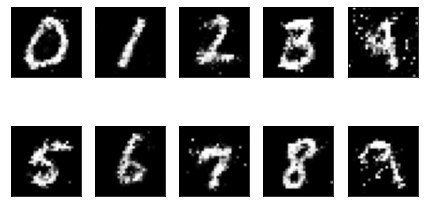

Epoch ==> 62/100, Discrim_loss=0.660, Generat_loss=0.849                                                                                                     
Epoch ==> 63/100, Discrim_loss=0.653, Generat_loss=0.840                                                                                                     
Epoch ==> 64/100, Discrim_loss=0.671, Generat_loss=0.881                                                                                                     
Epoch ==> 65/100, Discrim_loss=0.658, Generat_loss=0.831                                                                                                     
Epoch ==> 66/100, Discrim_loss=0.666, Generat_loss=0.885                                                                                                     
Epoch ==> 67/100, Discrim_loss=0.665, Generat_loss=0.873                                                                                                     
Epoch ==> 68/100, Discrim_loss=0.663, Generat_loss=0

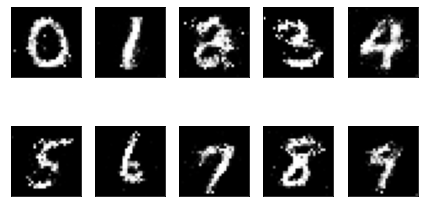

Epoch ==> 72/100, Discrim_loss=0.668, Generat_loss=0.853                                                                                                     
Epoch ==> 73/100, Discrim_loss=0.663, Generat_loss=0.849                                                                                                     
Epoch ==> 74/100, Discrim_loss=0.664, Generat_loss=0.867                                                                                                     
Epoch ==> 75/100, Discrim_loss=0.669, Generat_loss=0.890                                                                                                     
Epoch ==> 76/100, Discrim_loss=0.670, Generat_loss=0.881                                                                                                     
Epoch ==> 77/100, Discrim_loss=0.684, Generat_loss=0.844                                                                                                     
Epoch ==> 78/100, Discrim_loss=0.671, Generat_loss=0

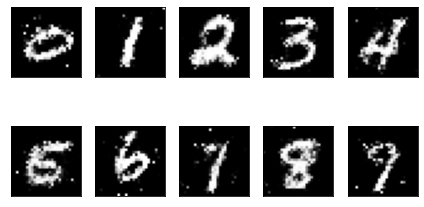

Epoch ==> 82/100, Discrim_loss=0.683, Generat_loss=0.828                                                                                                     
Epoch ==> 83/100, Discrim_loss=0.658, Generat_loss=0.869                                                                                                     
Epoch ==> 84/100, Discrim_loss=0.695, Generat_loss=0.876                                                                                                     
Epoch ==> 85/100, Discrim_loss=0.665, Generat_loss=0.863                                                                                                     
Epoch ==> 86/100, Discrim_loss=0.662, Generat_loss=0.862                                                                                                     
Epoch ==> 87/100, Discrim_loss=0.652, Generat_loss=0.882                                                                                                     
Epoch ==> 88/100, Discrim_loss=0.687, Generat_loss=0

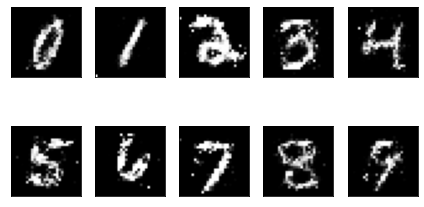

Epoch ==> 92/100, Discrim_loss=0.652, Generat_loss=0.833                                                                                                     
Epoch ==> 93/100, Discrim_loss=0.643, Generat_loss=0.871                                                                                                     
Epoch ==> 94/100, Discrim_loss=0.657, Generat_loss=0.851                                                                                                     
Epoch ==> 95/100, Discrim_loss=0.653, Generat_loss=0.859                                                                                                     
Epoch ==> 96/100, Discrim_loss=0.661, Generat_loss=0.846                                                                                                     
Epoch ==> 97/100, Discrim_loss=0.673, Generat_loss=0.894                                                                                                     
Epoch ==> 98/100, Discrim_loss=0.655, Generat_loss=0

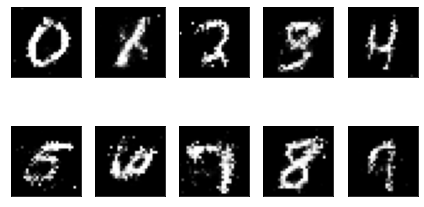

In [22]:
epochs = 100
batch_size = 64
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Discriminator
        discriminator.trainable = True
        
        # Real Images
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels], y=real * (1 - smooth))
        
        # Fake Images
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
         
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Generator 
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)
   
        print(
            'Epoch ==> %d/%d, batch = %d/%d, Discrim_loss=%.3f, Generat_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('Epoch ==> %d/%d, Discrim_loss=%.3f, Generat_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')
    if e % 10 == 0:
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = np.arange(0, 10).reshape(-1, 1)
        
        x_fake = generator.predict([z, labels])

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

In [23]:
X_train.shape

(60000, 784)

In [24]:
X_fake.shape

(64, 784)

In [27]:
import cv2
from skimage import measure
score1=0

real_img = X_train[:64]
real_imgsY = y_train[1]
img1=real_img
img2=X_fake
print(img1.shape)
print(img2.shape)
score, diff = measure.compare_ssim(img1, img2, full=True)
if score1 < score :
  score1=score
   
print("Highest SSIM: {}".format(score1))

(64, 784)
(64, 784)
Highest SSIM: 0.32846198446717584


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  # This is added back by InteractiveShellApp.init_path()


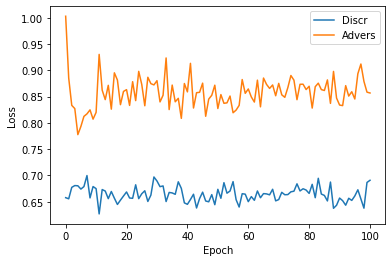

In [26]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discr', 'Advers'], loc=1)
plt.show()